In [2]:
# Imports

import numpy as np
import sounddevice as sd
import subprocess
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from os import listdir
from os.path import isdir, join
from IPython.display import clear_output
import time

2023-07-25 14:41:42.324802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load Model

# Charger le modèle TFLite
interpreter = tf.lite.Interpreter(model_path='all_targets.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

dataset_path = '../data_speech_commands_v0.02'
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
# Functions

# Définir les paramètres du traitement du signal
sample_rate = 8000  # Définir la fréquence d'échantillonnage appropriée
audio_duration = 1  # Durée de l'audio en secondes
num_mfcc = 16  # Nombre de coefficients MFCC à extraire

# Fonction pour calculer les coefficients MFCC à partir d'un fichier wav
def calc_mfcc_from_C(path):
    
    #Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    signal=signal*(2**15)
    signal = signal[0:8000]
    function=signal.astype(np.int16)
    #Stock the Wav data in the file time_series.dat
    np.savetxt('./time_series_1s.dat', function, fmt='%d', delimiter='\n') 
    
    # Call the C++ function to compute the MFCC from the time series
    subprocess.run(["./compute_mfcc"], shell=True)

    # Load the MFCC from the file mfcc_from_time_series.dat
    mfcc_from_time_series = np.genfromtxt('mfcc_from_time_series_1s.dat',delimiter='\n',dtype=None)
    # mfcc_from_time_series = mfcc_from_time_series.reshape(16,16)
    
    return mfcc_from_time_series

# Fonction pour effectuer une prédiction avec le modèle TFLite
def predict(input_data):
    input_shape = input_details[0]['shape']
    input_data =input_data.reshape(input_shape).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)
    probability = np.max(output_data)
    return predicted_class, probability


In [7]:
# Get Prediction

# Filenames to test
# filename  = '../data_speech_commands_v0.02/four/0a2b400e_nohash_0.wav'  #Four
# filename  = '../data_speech_commands_v0.02/right/0d6d7360_nohash_3.wav' #Right
# filename  = '../data_speech_commands_v0.02/stop/0a196374_nohash_0.wav'  #Stop
# filename  = '../data_speech_commands_v0.02/five/0a2b400e_nohash_3.wav'  #Five
# filename  = '../data_speech_commands_v0.02/eight/0b7ee1a0_nohash_0.wav' #Eight
# filename  = '../data_speech_commands_v0.02/zero/0a2b400e_nohash_3.wav'   #Zero
# filename  = '../data_speech_commands_v0.02/bird/0b40aa8e_nohash_1.wav'  #Bird
filename  = '../my_eight.wav'  #Eight

processed_data = calc_mfcc_from_C(filename)
predicted_class, probability = predict(processed_data)
print('Prédiction :', all_targets[predicted_class], '->', probability)

Prédiction : eight -> 0.73090655


../my_eight.wav


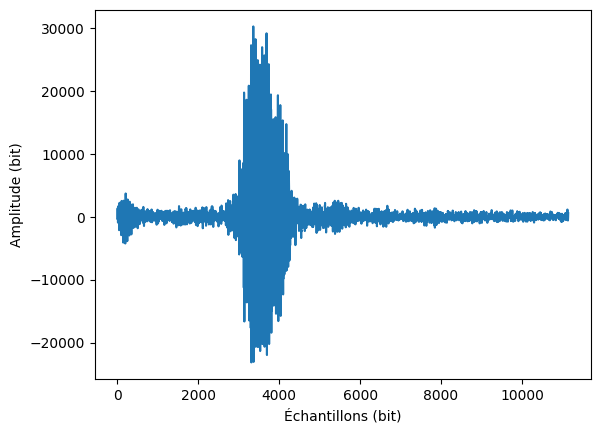

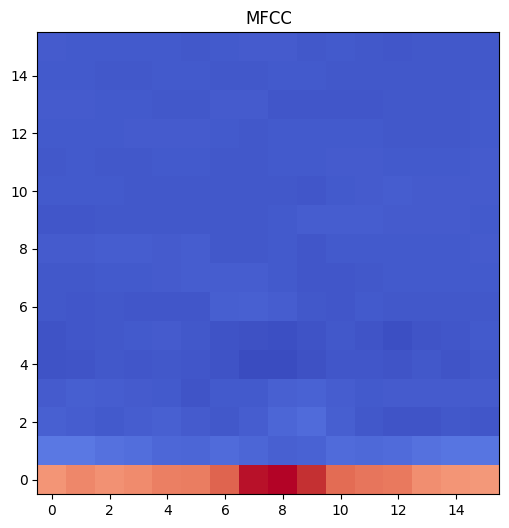

In [10]:
# Plot Signal & MFCC

mfccs = calc_mfcc_from_C(filename)
print(filename)

# Signal
signal, fs = librosa.load(filename, sr=8000)
# Mise à l'échelle des amplitudes en bit (pour un encodage 16 bits)
signal_en_bit = signal * (2 ** 15)
signal = signal[0:8000]
plt.plot(signal_en_bit)
plt.xlabel('Échantillons (bit)')
plt.ylabel('Amplitude (bit)')
plt.show()

# MFCC
mfcc_from_time_series = mfccs.reshape(16,16)
fig, ax = plt.subplots(figsize=(6,6))
mfcc_from_time_series= np.swapaxes(mfcc_from_time_series, 0 ,1)
cax = ax.imshow(mfcc_from_time_series, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()